# Convergence tests for finite differencing
If a finite differencing method is applied correctly, then as the discretization size goes to zero, we should see that
the solution converges. This means that we should find that as the step size $\Delta t$ is made smaller, the effect of that change should make a smaller change on the solution produced. We will simulate the system forward a certain amount of time at a given time step $\Delta t$, we will then halve the time step and run the same simulation. This will produce two different results, where hopefully the second is more accurate. We will measure the norm difference between these results and then continue halving $\Delta t$, the desired result is that as we keep on halving $\Delta t$, the normed difference should go to zero.

In [3]:
using PyPlot
using ForwardDiff
# Change this to the location of finiteDifferences.jl on your machine.
include("C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\src\\finiteDifferences.jl")
using FiniteDifferences

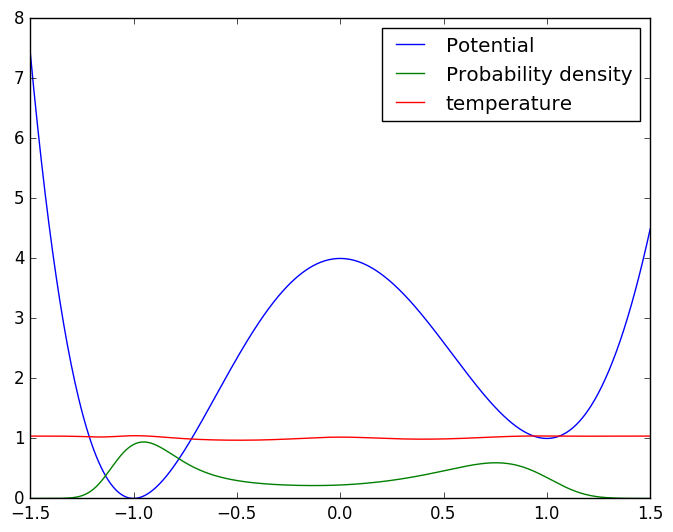

  1.951501 seconds (2.16 M allocations: 2.392 GB, 17.50% gc time)


PyObject <matplotlib.legend.Legend object at 0x000000001F4AE2E8>

In [6]:
# Initialize the system and plot an example evolution.
LL = 1.0  # Length scale of the system.
T0 = 1.0  # Temperature. 

alpha = 1e-2
beta = 0.0001

nPoints = 500 # The number of points on the xAxis
nSteps = 5000
dt = 1e-5  # Time step.

extend = 1.5
xAxis = linspace(-extend*LL, extend*LL, nPoints)
dx = (xAxis[end] - xAxis[1])/nPoints # Grid spacing

coeff = hermite_coeff([-1.0, 0.0, 1.0], [0.0, 8.0, 2.0], [0.0, 0.0, 0.0])
function V(x, coeff)
    acc = 0
    for ii = 1:length(coeff)
        acc += coeff[ii]*x^(ii-1)
    end
    acc
end
V(x) = V(x, coeff)
dV(x) = ForwardDiff.derivative(V, x)

potential = Float64[V(x) for x in xAxis]
dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)]

tempFun(x) = T0
temperature = Float64[tempFun(x) for x in xAxis]

sigma  = 0.1
P0 = Float64[(1/(sigma*sqrt(2pi)))*exp(-((x - 0.0)^2)/(2sigma^2))
              for x in xAxis]
P0 /= discrete_quad(P0, xAxis[1], xAxis[end])
density = P0

T = Array(Float64, nPoints, nSteps)
T[:, 1] = temperature
P = Array(Float64, nPoints, nSteps)
P[:, 1] = density
energy = energyFun(potential, density, temperature, alpha, xAxis)
@time begin
    for i in 2:nSteps
        density = stepP(density, dt, dpotential, temperature, xAxis; bndType = :absorbing, normalization = true)
        temperature = stepT(temperature, dt, density, potential, dpotential, alpha,
            beta, energy, xAxis; bndType=:neumann)
    end
end

plot(xAxis, 0.5potential, xAxis, density, xAxis, temperature)
legend(["Potential", "Probability density", "temperature"])

Probability convergence rate = 11.6164814880239


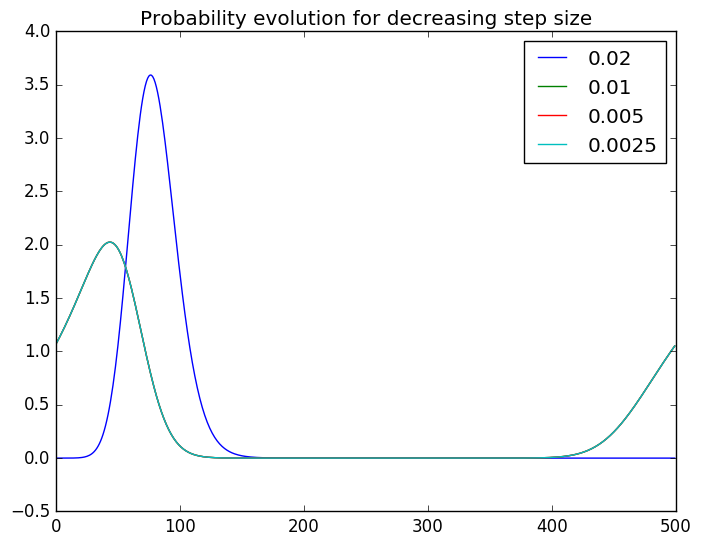

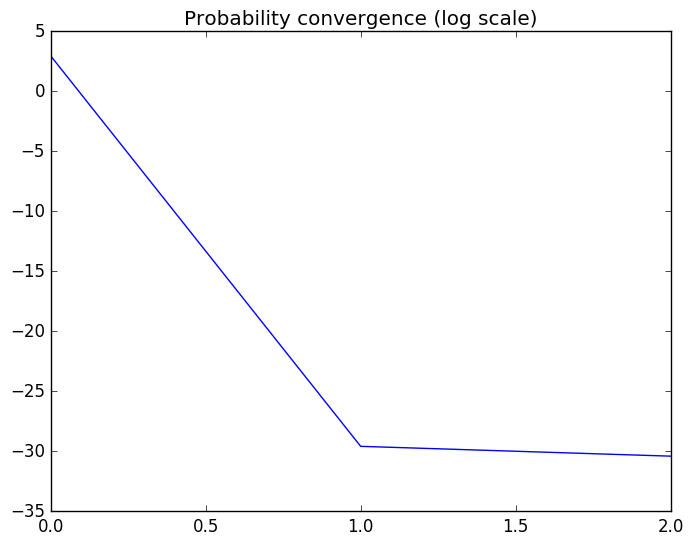

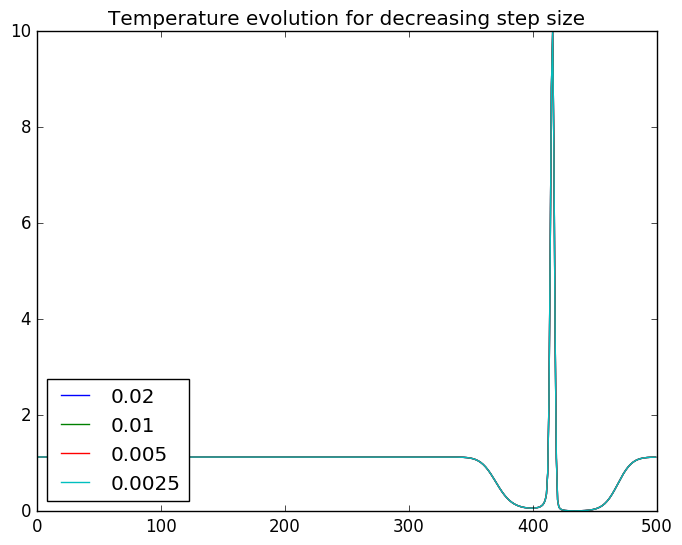

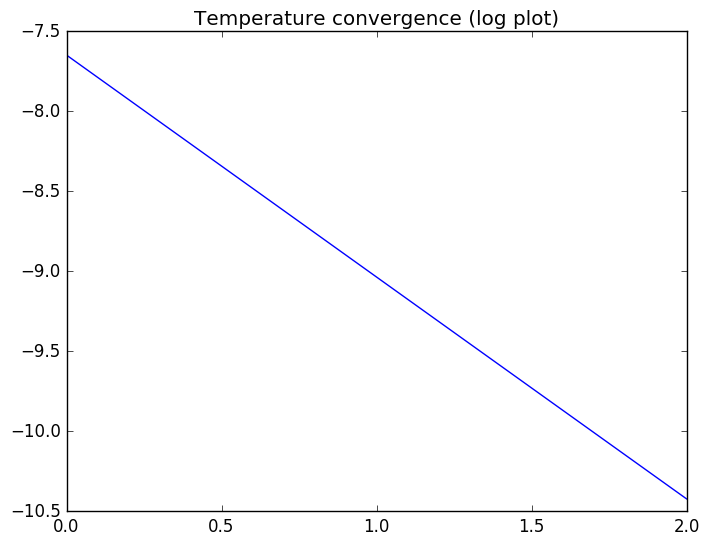

Temperature convergence rate = 0.9383431053859703


PyObject <matplotlib.text.Text object at 0x000000001ED29E80>

In [3]:
# Test for convergence, we will test the convergence of the stepP and the stepT functions seperately, the temperature
# case is a little un-physical (Brownian particle is not moving but there is still heat?). I have only included it as
# a way to test the numerics.
T0 = 1.0  # Temperature.
alpha = 1e-2
beta = 1e-4
evolveTime = 2.0
scaling = 1e-2
dtVec = [2, 1, 1/2, 1/4]*scaling  

sigma  = 0.1
P0 = Float64[(1/(sigma*sqrt(2pi)))*exp(-((x - 1.0)^2)/(2sigma^2))
              for x in xAxis]
P0 /= discrete_quad(P0, xAxis[1], xAxis[end])
tempFun(x) = T0
temperature = Float64[tempFun(x) for x in xAxis]

density = P0
Parray = Array(Float64, nPoints, length(dtVec))
Tarray = Array(Float64, nPoints, length(dtVec))
index = 1
energy = energyFun(potential, density, temperature, alpha, xAxis)
for dt in dtVec
    Parray[:, index] = evolveP(density, evolveTime, dt, dpotential,
                                temperature, xAxis)
    Tarray[:, index] = evolveT(temperature::AbstractArray, evolveTime, dt,
                            potential, dpotential, density, alpha, beta, energy, xAxis)
    index += 1
end
# Calculate the distances between adjacent probability distributions.
norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
println("Probability convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
plot(Parray)
title("Probability evolution for decreasing step size")
legend(dtVec)
figure()
plot(log(norms))
title("Probability convergence (log scale)")
# Calculate the distances between adjacent temperature distributions.
norms = Float64[norm(Tarray[:, i] - Tarray[:, i-1]) for i in 2:length(dtVec)]
println("Temperature convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
figure()
plot(Tarray)
title("Temperature evolution for decreasing step size")
legend(dtVec, loc = 3)
figure()
plot(log(norms))
title("Temperature convergence (log plot)")

As you can see, the periodic boundary conditions are causing the system to do some very wierd things, I think that the same wierd things are happening with absorbing boundary conditions, but their effect is harder to visualize.

In [4]:
# Test the convergence rate for a different potential.
scaling = 2.5e-2
dtVec = [1, 1/2, 1/4, 1/8]*scaling
V(x) = 2cos(2pi*x)
dV(x) = ForwardDiff.derivative(V, x)
potential = Float64[V(x) for x in xAxis]
dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)]
density = Float64[(1/(sigma*sqrt(2pi)))*exp(-(x^2)/(2sigma^2))
              for x in xAxis]

Parray = Array(Float64, nPoints, length(dtVec))
Tarray = Array(Float64, nPoints, length(dtVec))
index = 1
energy = energyFun(potential, density, temperature, alpha, xAxis)
for dt in dtVec
    Parray[:, index] = evolveP(density, evolveTime, dt, dpotential,
                            temperature, xAxis; probBndType = :periodic)
    Tarray[:, index] = evolveT(temperature::AbstractArray, evolveTime::Number, dt::Number,
                            potential, dpotential, density, alpha, beta, energy, xAxis)
    index += 1
end

In [5]:
dx, nPoints

(0.006,500)

Probability convergence rate = 8.205775651546956


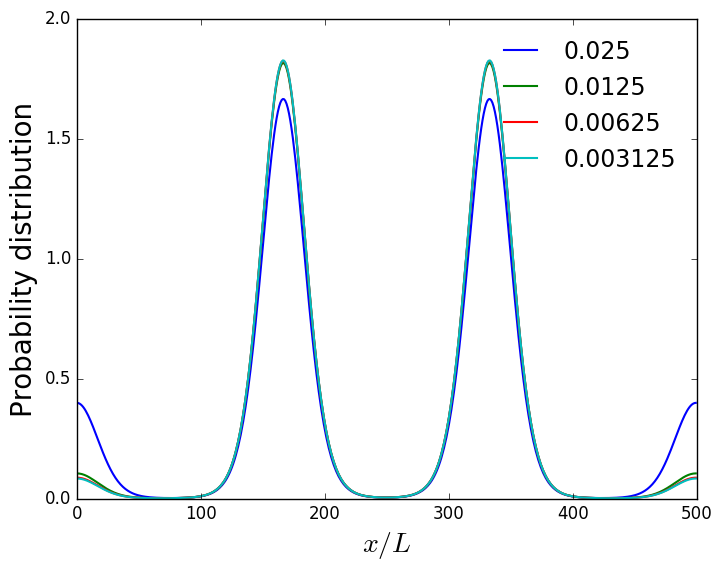

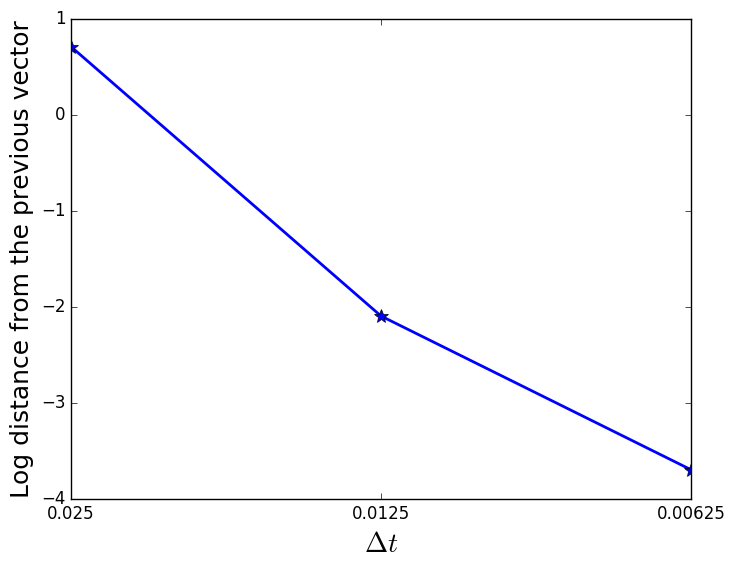

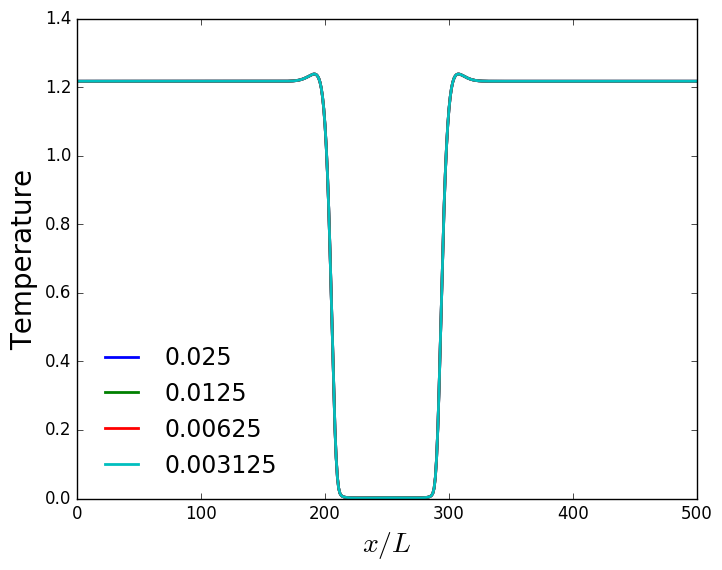

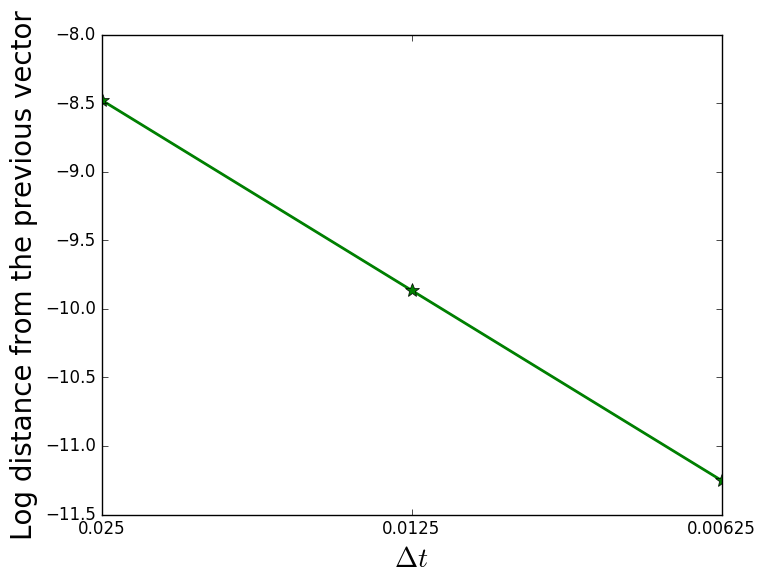

Temperature convergence rate = -1.0312054047075665


(Any[PyObject <matplotlib.axis.XTick object at 0x00000000280C7BE0>,PyObject <matplotlib.axis.XTick object at 0x00000000280C7A90>,PyObject <matplotlib.axis.XTick object at 0x000000001F28D0B8>],Any[PyObject <matplotlib.text.Text object at 0x00000000280EC898>,PyObject <matplotlib.text.Text object at 0x000000002817AF28>,PyObject <matplotlib.text.Text object at 0x000000001F281C88>])

In [6]:
# Calculate the distances between adjacent probability distributions.
labels = dtVec
norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
println("Probability convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
plot(Parray, linewidth = 1.5)
xlabel(L"x / L", fontsize = 20)
ylabel("Probability distribution", fontsize = 20)
legend(dtVec, fontsize = 17, frameon = false)
# savefig("$(figureDirectory)\\probabilityConvergence.pdf")

# title("Probability evolution for decreasing step size")
figure()
plot(log(norms), "-*", linewidth = 2, markersize = 10)
xlabel(L"\Delta t", fontsize = 20)
ylabel("Log distance from the previous vector", fontsize = 18)
xticks(0:length(norms)-1, labels[1:end-1])
# savefig("$(figureDirectory)\\probabilityConvergenceRate.pdf")

# title("Probability convergence (log scale)")
# Calculate the distances between adjacent temperature distributions.
norms = Float64[norm(Tarray[:, i] - Tarray[:, i-1]) for i in 2:length(dtVec)]
println("Temperature convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
figure()
plot(Tarray, linewidth = 2)
xlabel(L"x / L", fontsize = 20)
ylabel("Temperature", fontsize = 20)
# title("Temperature evolution for decreasing step size")

legend(dtVec, loc = 3, fontsize = 17, frameon = false)
# savefig("$(figureDirectory)\\temperatureConvergence.pdf")
figure()
plot(log(norms))
# title("Temperature convergence (log scale)")
plot(log(norms), "-*", linewidth = 2, markersize = 10)
xlabel(L"\Delta t", fontsize = 20)
ylabel("Log distance from the previous vector", fontsize = 20)
xticks(0:length(norms)-1, labels[1:end-1])
# savefig("$(figureDirectory)\\temperatureConvergenceRate.pdf")

Probability convergence rate = 8.36859281588528


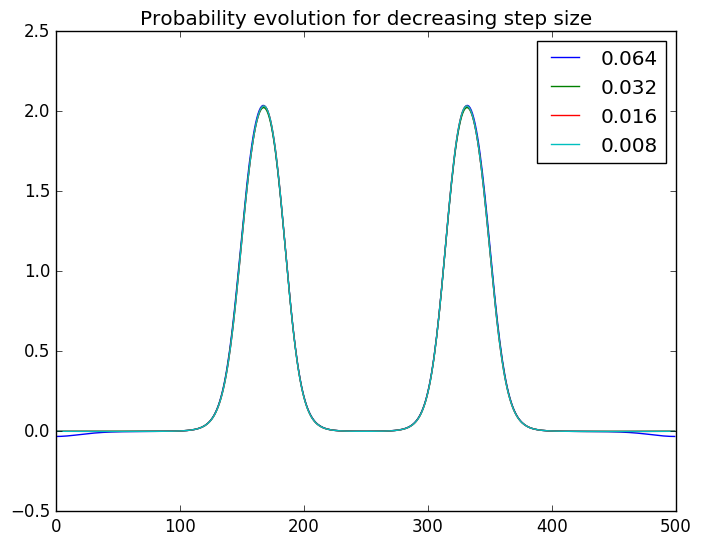

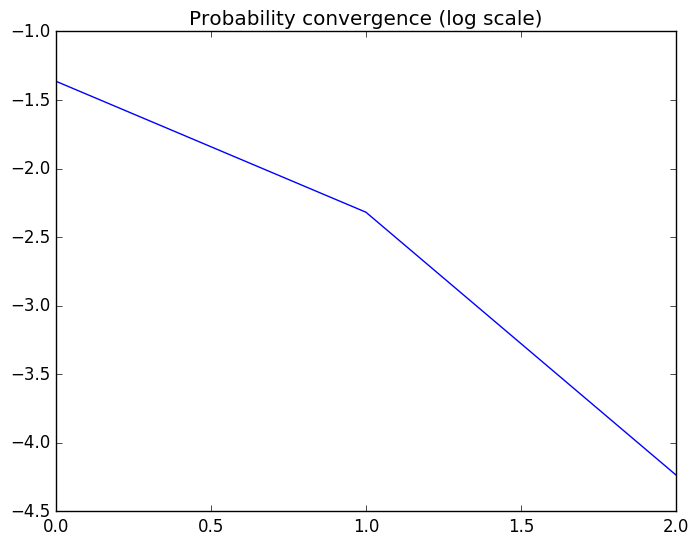

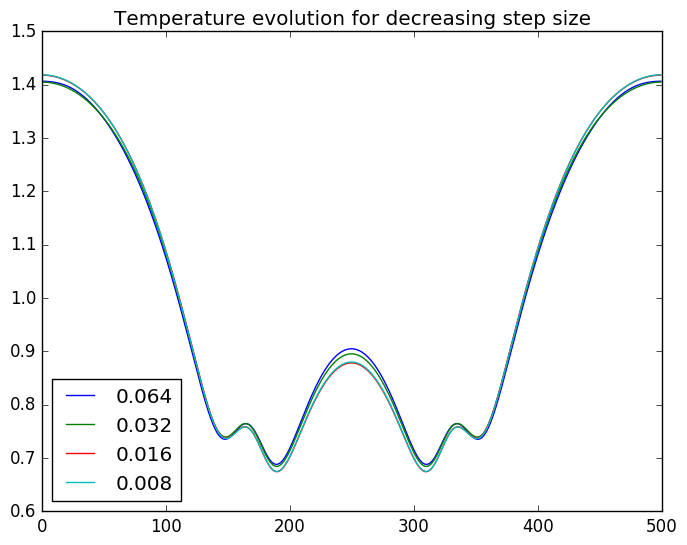

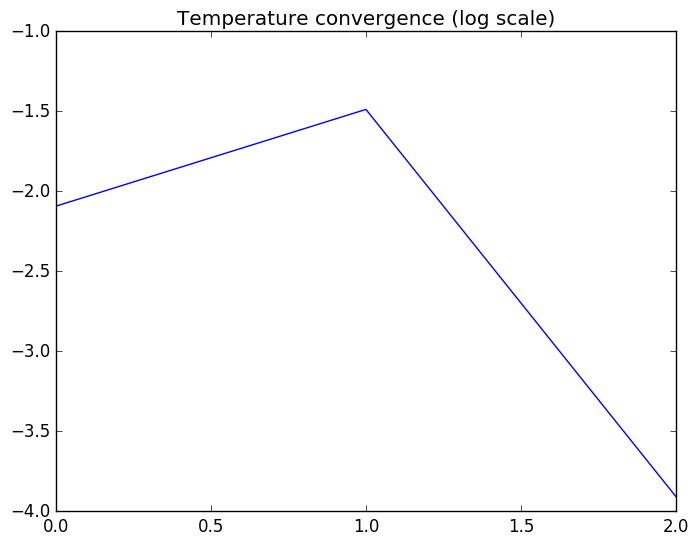

Temperature convergence rate = 7.520648518862395


PyObject <matplotlib.text.Text object at 0x000000001E85AC50>

In [7]:
# Test the convergence rate for the system evolution.
scaling = 1.0e-3
evolveTime = 1.0
# dtVec = [32.0, 16.0, 8.0, 4.0, 2.0, 1.0]*scaling
dtVec = [64.0, 32.0, 16.0, 8.0]*scaling
index = 1
alpha = 1e-2
beta = 0.1
energy = energyFun(potential, density, temperature, alpha, xAxis)
Parray = Array(Float64, nPoints, length(dtVec))
Tarray = Array(Float64, nPoints, length(dtVec))
for dt in dtVec
    Parray[:, index], Tarray[:, index] = evolve_system(density, temperature, evolveTime, dt,
            potential, dpotential, alpha, beta, energy, xAxis ; 
    tempBndType = :neumann, probBndType = :periodic)
    index += 1
end

# Calculate the distances between adjacent probability distributions.
norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
println("Probability convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
plot(Parray)
title("Probability evolution for decreasing step size")
legend(dtVec)
figure()
plot(log(norms))
title("Probability convergence (log scale)")
# Calculate the distances between adjacent temperature distributions.
norms = Float64[norm(Tarray[:, i] - Tarray[:, i-1]) for i in 2:length(dtVec)]
println("Temperature convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
figure()
plot(Tarray)
title("Temperature evolution for decreasing step size")
legend(dtVec, loc = 3)
figure()
plot(log(norms))
title("Temperature convergence (log scale)")

In [8]:
dtVec

4-element Array{Float64,1}:
 0.064
 0.032
 0.016
 0.008

In [22]:
figureDirectory = "C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\Thesis\\Figures"

plot(xAxis, Parray)
legend(dtVec)
title("The convergence of the probabilty distribution in a sinusoidal potential")
xlabel("x")
ylabel("Probability density")
# norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
# plot(log(norms), "b-*")
# title("Difference between sucessive iterations (log scale)")
# xlabel("Step number")
# ylabel("log of the normed difference")
# savefig("$(figureDirectory)\\probabilityConvergence.pdf")

LoadError: LoadError: UndefVarError: Parray not defined
while loading In[22], in expression starting on line 3

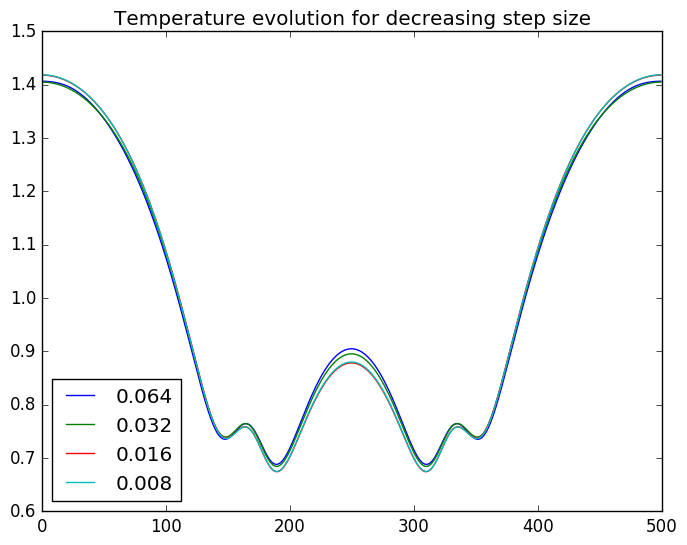

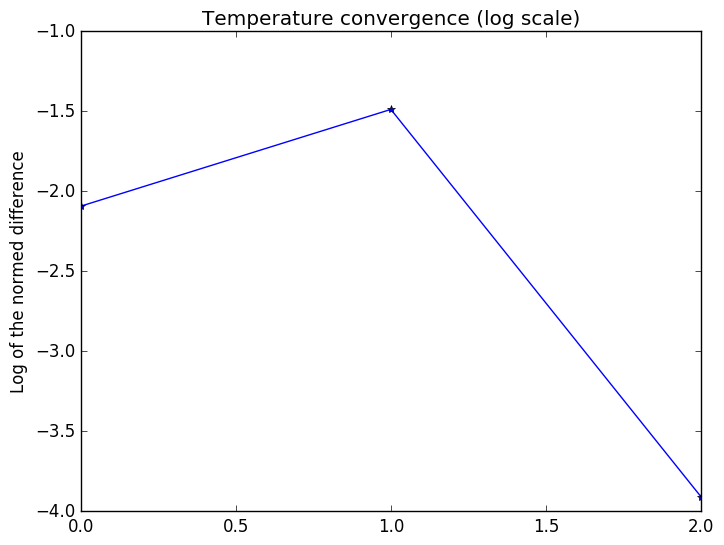

PyObject <matplotlib.text.Text object at 0x000000001EDF07F0>

In [10]:
plot(Tarray)
title("Temperature evolution for decreasing step size")
legend(dtVec, loc = 3)
# savefig("$(figureDirectory)\\temperatureConvergence.pdf")
figure()
plot(log(norms), "-*")
title("Temperature convergence (log scale)")
ylabel("Log of the normed difference")
# savefig("$(figureDirectory)\\temperatureNormDiff.pdf")

In [10]:
# Convergence for dx.
To = 1
alpha = 5e-4
beta = 1e-2
nSteps = 4000
Pdict = Dict()
Tdict = Dict()
xAxisDict = Dict()
nPointsVec = [20, 40, 80, 160, 320, 640, 1280, 1280*2]
# nPointsVec = [20, 40, 80, 800]
index = 1
for nPoints in nPointsVec
    extend = 2.5
    xAxis = linspace(-extend*LL, extend*LL, nPoints)
    dx = (xAxis[end] - xAxis[1])/nPoints # Grid spacing

#     coeff = hermite_coeff([-1.0, 0.0, 1.0], [0.0, 8.0, 2.0], [0.0, 0.0, 0.0])
#     function V(x, coeff)
#         acc = 0
#         for ii = 1:length(coeff)
#             acc += coeff[ii]*x^(ii-1)
#         end
#         acc
#     end
#     V(x) = V(x, coeff)
#     dV(x) = ForwardDiff.derivative(V, x)
    
    V(x) = x^2 + cos(2pi*x) + 1
    dV(x) = ForwardDiff.derivative(V, x)
    
    potential = Float64[V(x) for x in xAxis]
    dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)]

    tempFun(x) = T0 + 0.6sin(2pi*x) + exp(-x^2)
    temperature = Float64[tempFun(x) for x in xAxis]

    
    
    sigma  = 0.4
    P0 = Float64[(1/(sigma*sqrt(2pi)))*exp(-((x - 1.0)^2)/(2sigma^2))
                  for x in xAxis]
    P0 /= discrete_quad(P0, xAxis[1], xAxis[end])
    density = P0
    
    # Make the system.
    system = System()
    system.density = density
    system.potential = potential
    system.dpotential = dpotential
    system.temperature = temperature
    system.xAxis = xAxis
    system.energy = energyFun(system, alpha)
    
    for i in 1:nSteps
        system.energy, system.temperature = stepT(system, alpha, beta, dt, bndType = :dirichlet)
        system.density = stepP(system, dt)
    end
    xAxisDict[index] = system.xAxis
    Pdict[index] = system.density
    Tdict[index] = system.temperature
    index += 1
end

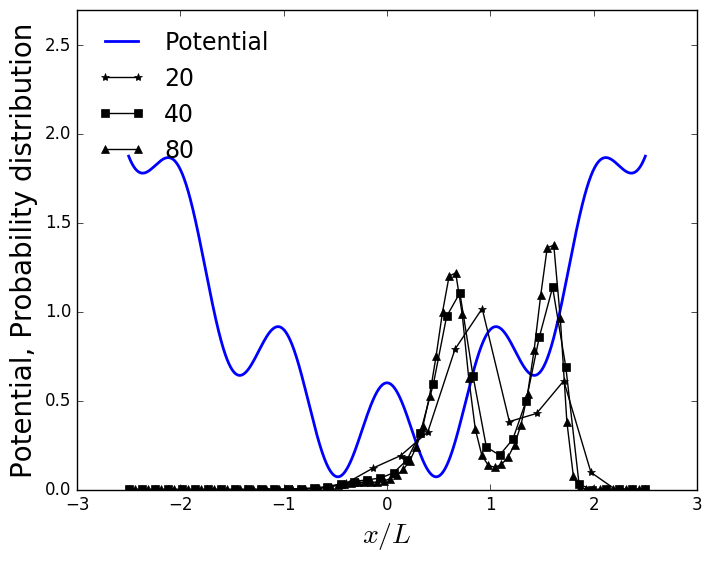

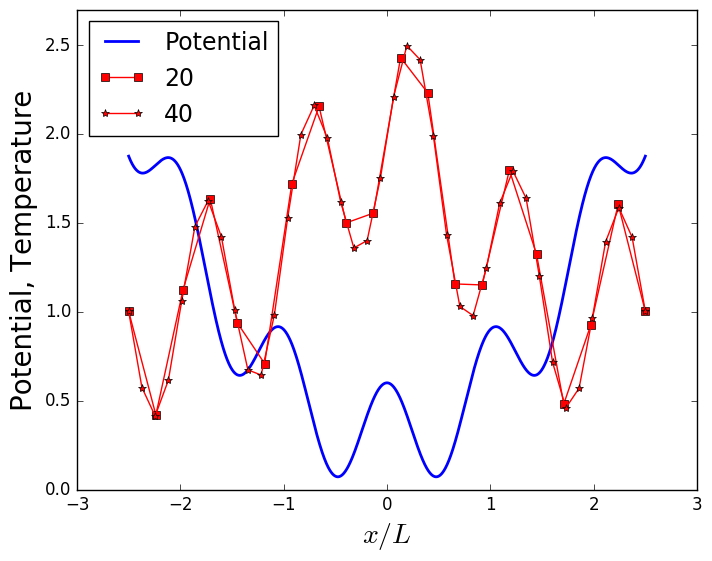

(0.0,2.7)

In [11]:
plot(xAxis, 0.3potential, "b", linewidth = 2)
plot(xAxisDict[1], Pdict[1], "-*", color="black")
plot(xAxisDict[2], Pdict[2], "-s", color="black")
plot(xAxisDict[3], Pdict[3], "-^", color="black")
# title("Convergence as the number of points is increased")
xlabel(L"x / L", fontsize = 20)
ylabel("Potential, Probability distribution", fontsize = 20)
legend(["Potential" ; nPointsVec[1:end-1]], loc=2, frameon = false, fontsize = 17)
ylim([0, 2.7])
# savefig("$(figureDirectory)\\spaceConvergenceDensity.pdf")

figure()
plot(xAxis, 0.3potential, "b", linewidth = 2)
plot(xAxisDict[1], Tdict[1], "-s", color="red")
plot(xAxisDict[2], Tdict[2], "-*", color="red")
# plot(xAxisDict[3], Tdict[3], "-^", color="red")
legend(["Potential" ; nPointsVec[1:end-1]], loc=2, fontsize = 17)
# title("Convergence as the number of points is increased")
xlabel(L"x / L", fontsize = 20)
ylabel("Potential, Temperature", fontsize = 20)
ylim([0, 2.7])
# savefig("$(figureDirectory)\\spaceConvergenceTemperature.pdf")

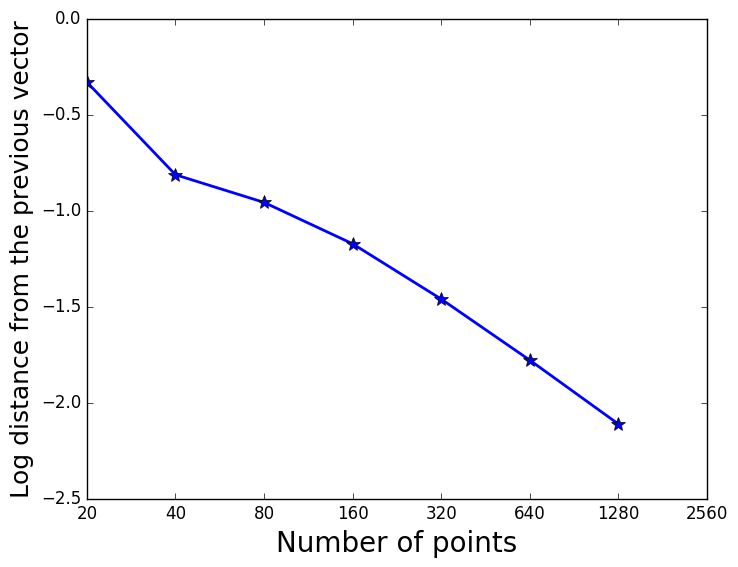

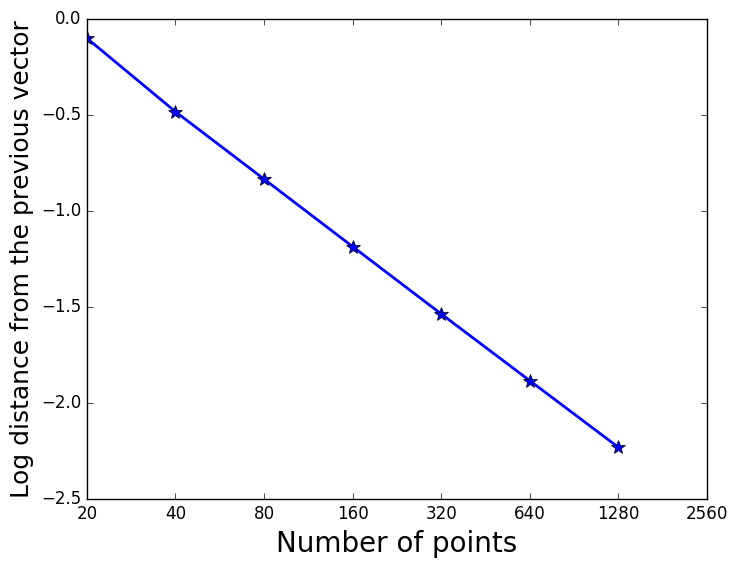

In [23]:
labels = map(string, nPointsVec)
norms = Float64[norm(Pdict[i][1:2:end] - Pdict[i-1]) for i in 2:length(nPointsVec)]
plot(log(norms), "-*", linewidth = 2, markersize = 10)
xticks(0:(length(nPointsVec) - 1), labels)
# title("The convergence of the probability distribution", fontsize = 20)
xlabel("Number of points", fontsize = 20)
ylabel("Log distance from the previous vector", fontsize = 18)
# savefig("$(figureDirectory)\\densityConvergenceSpace.pdf")

figure()
norms = Float64[norm(Tdict[i][1:2:end] - Tdict[i-1]) for i in 2:length(nPointsVec)]
plot(log(norms), "-*", linewidth = 2, markersize = 10)
xticks(0:(length(nPointsVec) - 1), labels)
# title("The convergence of the temperature", fontsize = 20)
xlabel("Number of points", fontsize = 20)
ylabel("Log distance from the previous vector", fontsize = 18)
# savefig("$(figureDirectory)\\temperatureConvergenceSpace.pdf")

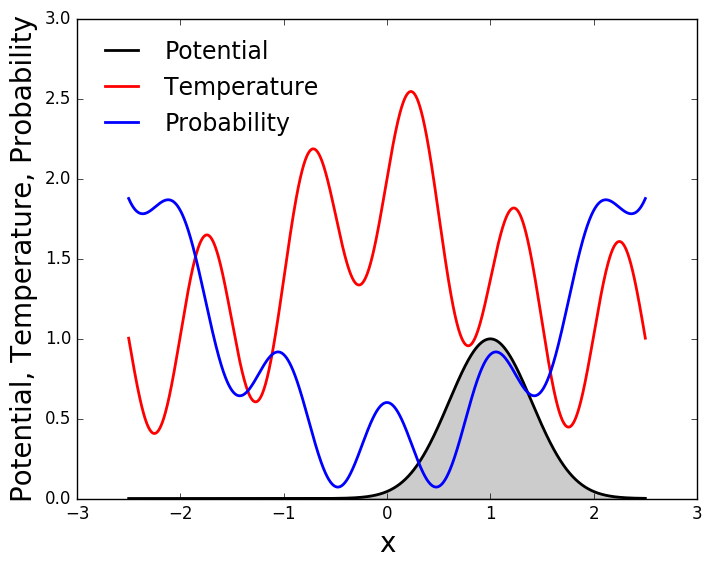

PyObject <matplotlib.legend.Legend object at 0x000000001F707748>

In [13]:
# Plot the initial configuration.
plot(xAxis, density, color="black", linewidth = 2)
fill_between(xAxis, density, color="black", alpha = 0.2)
plot(xAxis, temperature, "r", linewidth = 2)
plot(xAxis, 0.3potential, "b", linewidth = 2)
# title("Initial configuration")
xlabel("x", fontsize = 20)
ylabel("Potential, Temperature, Probability", fontsize = 20)
legend(["Potential", "Temperature", "Probability"], loc=2, frameon = false, fontsize = 17)
# savefig("$(figureDirectory)\\spaceConvergenceInit.pdf")